In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')
sns.set()

### FUNCTIONS USED IN THIS EDA

In [3]:
# возвращает первую и третью квантили, а также межквартильный диапазон,
# но не очищает выбросы


def calc_outliers(db_col):
    Q1 = db_col.quantile(0.25)
    Q3 = db_col.quantile(0.75)
    IQR = Q3-Q1
    return(Q1, Q3, IQR)

In [4]:
# заменяет пустые значения в заданной колонке на значение 'exch'

def empty_to_value(column, exch):
    data[column] = data[column].apply(lambda x: exch if pd.isnull(x) else x)

In [5]:
# если пустых данных в столбцах не более 5%, то их замена на медианное
# значение не может сильно исказить конечный результат


def act_w_categ(column):

    T = data[column].count()
    E = data[column].isna().sum()

    if E/T <= 0.05:
        empty_to_value(column, data[column].value_counts().index[0])
    else:
        print(f'В столбце {column} слишком много пустых значений:\
        {E} из {T}  ({round(E/T*100,2)}%). \
        Невозможно заполнить на данном этапе')

In [6]:
# создает графическое пространство для построения графиков типа 'boxplot', для
# визуальной оценки влияния категорийных признаков на 'score'


def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(x=column, y='score', data=data)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [7]:
# проводит тест Стьюдента для нулевой гипотезы, согласно которой показатели
# 'score' в рамках одного категорийного признака практически одинаковы


def get_stat_dif(column):
    cols = data.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'score'],
                     data.loc[data.loc[:, column] == comb[1], 'score']).pvalue <= 0.05/len(combinations_all):
            print('Найдены статистически значимые различия для колонки', column)
            break

### DATA LOADING AND OVERVIEW

In [8]:
data = pd.read_csv('stud_math.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

числ 13 строк 17

In [9]:
data.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,...,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,...,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,...,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,...,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,...,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


для удобства работы переименуем столбец 'studytime, granular' 'studytime_granular', а также разобъем колонки исходя из их содержания на числовые и категориальные

In [10]:
data.rename(
    columns={'studytime, granular': 'studytime_granular'}, inplace=True)

In [11]:
numeric = ['age', 'absences', 'score']
categorial = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu',
              'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
              'studytime', 'failures', 'schoolsup', 'famsup', 'paid',
              'activities', 'nursery', 'higher',
              'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health']

в задании отсутствует описание столбца 'studytime_granular' и в данных есть столбец 'studytime'. Проверим насколько эти два столбца скореллировны

In [12]:
temp = pd.DataFrame({'col1': data.studytime, 'col2': data.studytime_granular})
temp.corr()

,col1,col2
col1,1.0,-1.0
col2,-1.0,1.0


очевидна полная обратная корелляция, поэтому столбец 'studytime_granular' можно убрать

In [13]:
data = data.drop('studytime_granular', axis=1)

#### numeric

In [14]:
data[numeric].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       395 non-null    int64  
 1   absences  383 non-null    float64
 2   score     389 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 9.4 KB


в числовых данных мало пропусков, можно заменить их на медианное значение

In [15]:
for column in numeric:
    empty_to_value(column, data[column].median())

In [16]:
data[numeric].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       395 non-null    int64  
 1   absences  395 non-null    float64
 2   score     395 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 9.4 KB


##### age

In [17]:
data.age.describe()

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

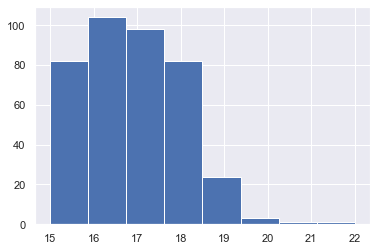

In [18]:
data.age.hist(bins=data.age.nunique())

In [19]:
Q1 = calc_outliers(data.age)[0]
Q3 = calc_outliers(data.age)[1]
IQR = calc_outliers(data.age)[2]

data[(data['age'] > Q3+1.5*IQR) | (data['age'] < Q1-1.5*IQR)]['age'].value_counts()

22    1
Name: age, dtype: int64

пустых строк нет; Распределение сдвинуто влево, заметно сильное сокращение учащихся старше 18 лет, что, предположительно, указывает на то, что большая часть учащихся заканчивает школу в возрасте не старше этого возраста. Единственного учащегося в возрасте 22 лет по формуле межквартильного диапазона можно было бы отсеить, как выброс, однако, можно предположить, что более возрастные учащиеся будут иметь низкую посещаемость и/или низкие оценки. Проверим при анализе. Если гипотеза подтвердится, это будет означать, что возрастные ученики входят в группу риска.  

##### absences

In [20]:
data.absences.describe()

count    395.000000
mean       7.179747
std       23.111967
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

Пустых значений нет. Очевидно разброс очень большой, проверим на наличие выбросов

In [21]:
Q1 = calc_outliers(data.absences)[0]
Q3 = calc_outliers(data.absences)[1]
IQR = calc_outliers(data.absences)[2]

over_abs = data[~data.absences.between(Q1-1.5*IQR, Q3+1.5*IQR)]
over_abs

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,...,no,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,...,yes,yes,yes,no,4.0,NaN,3.0,5.0,54.0,55.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,...,yes,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
183,GP,F,17,U,LE3,NaN,3.0,3.0,other,other,...,yes,yes,yes,yes,5.0,3.0,3.0,1.0,56.0,40.0
198,GP,F,17,U,GT3,NaN,4.0,4.0,services,teacher,...,yes,yes,NaN,no,4.0,2.0,4.0,2.0,24.0,90.0
205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,...,yes,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,NaN,...,yes,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,...,yes,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
260,GP,F,18,U,GT3,NaN,4.0,3.0,NaN,other,...,yes,yes,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0
276,GP,F,18,R,GT3,A,3.0,2.0,other,services,...,no,no,yes,yes,NaN,1.0,1.0,5.0,75.0,45.0


In [22]:
over_abs.absences.describe()

count     17.000000
mean      64.882353
std       94.309253
min       21.000000
25%       23.000000
50%       28.000000
75%       54.000000
max      385.000000
Name: absences, dtype: float64

слишком много данных потеряем, если избавиться от выбросов, однако, судя по максимальному значению, есть очень сильно отличающиеся данные в самом диапазоне выбросов, попробуем отсечь хотя бы их

In [23]:
Q1 = calc_outliers(over_abs.absences)[0]
Q3 = calc_outliers(over_abs.absences)[1]
IQR = calc_outliers(over_abs.absences)[2]


over_abs[~over_abs.absences.between(Q1-1.5*IQR, Q3+1.5*IQR)].absences

222    385.0
390    212.0
Name: absences, dtype: float64

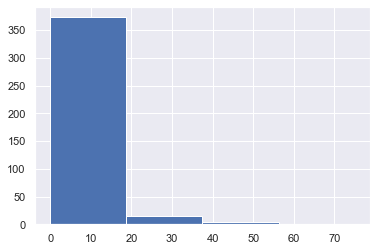

In [24]:
data.absences = data[data.absences < 212].absences
data.absences.hist(bins=4)

большая часть учащихся пропускает не более 20 занятий, при анализе надо проверить успеваемость остальных

##### score

In [25]:
data.score.describe()

count    395.000000
mean      52.303797
std       22.746314
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Значений 'nan' не много; заполним их медианным значением

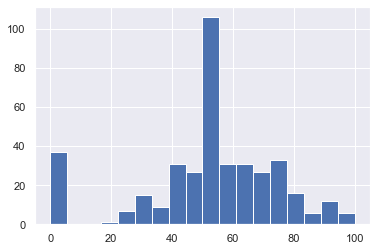

In [26]:
data.score.hist(bins=data.score.nunique())

Гистограма распределена нормально, но вызывает вопрос большое количество нулевых баллов. Возможно, это ошибочные данные, либо есть прямая связь с посещаемостью. 

In [27]:
data[data.score == 0]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
128,GP,M,18,R,NaN,T,2.0,2.0,NaN,other,...,yes,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
130,GP,F,15,R,GT3,T,3.0,4.0,services,teacher,...,yes,yes,yes,yes,4.0,2.0,2.0,5.0,0.0,0.0
131,GP,F,15,U,GT3,NaN,1.0,1.0,at_home,other,...,no,yes,yes,yes,4.0,NaN,3.0,4.0,0.0,0.0
134,GP,M,15,R,GT3,T,3.0,4.0,at_home,teacher,...,yes,yes,no,yes,5.0,3.0,3.0,5.0,0.0,0.0
135,GP,F,15,U,GT3,T,4.0,4.0,services,NaN,...,yes,yes,yes,yes,4.0,3.0,3.0,5.0,0.0,0.0
136,GP,M,17,R,GT3,T,3.0,4.0,at_home,other,...,yes,yes,no,no,NaN,4.0,5.0,5.0,0.0,0.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,...,no,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,...,yes,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
144,GP,M,17,U,GT3,T,2.0,1.0,other,other,...,yes,yes,yes,no,5.0,4.0,5.0,5.0,0.0,0.0
146,GP,F,15,U,GT3,T,3.0,2.0,health,services,...,yes,yes,yes,no,3.0,3.0,2.0,3.0,0.0,0.0


во всех строках, где score =0, также =0 и  absences, при этом остальные значения заполнены различающимися значениями, что позволяет предположить, что в данных допущена ошибка и вместо нулей в score и absences должны стоять реальные пропуски занятий и оценки. Во избежаниe потери большого количества данных ровно как и их сильного искажения, заменим нули в обоих столбцах на их медианные значения

In [28]:
data.score = data.score.apply(lambda x: data.score.median() if x == 0 else x)

In [29]:
data.absences = data.absences.apply(
    lambda x: data.absences.median() if x == 0 else x)

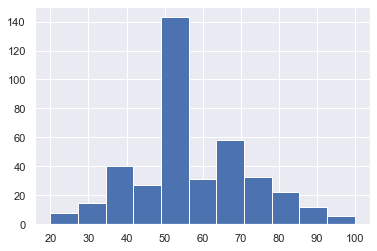

In [30]:
data.score.hist(bins=11, align='mid')

Выделяется большое число 50-56 -балльных оценок, что говорит о большом количестве 'среднячков'. Поскольку наша задача состоит в построении модели, которая может определить учащихся, потенциально находящихся в группе риска, то следует обратить особое внимание на баллы до 50.  

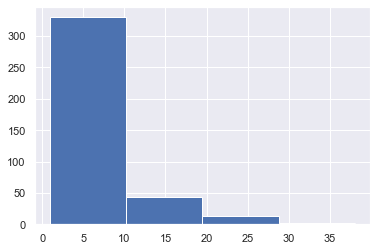

In [31]:
data.absences[data.absences < 40].hist(bins=4)

большая часть учащихся (около 350) посещает занятия с минимальными пропусками - до 10. При анализе надо будет обратить отдельное вниамние на учащихся с большим количеством пропусков и проследить взаимосвязь с оценками 

#### categorial

In [32]:
data[categorial].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   address     378 non-null    object 
 3   famsize     368 non-null    object 
 4   Pstatus     350 non-null    object 
 5   Medu        392 non-null    float64
 6   Fedu        371 non-null    float64
 7   Mjob        376 non-null    object 
 8   Fjob        359 non-null    object 
 9   reason      378 non-null    object 
 10  guardian    364 non-null    object 
 11  traveltime  367 non-null    float64
 12  studytime   388 non-null    float64
 13  failures    373 non-null    float64
 14  schoolsup   386 non-null    object 
 15  famsup      356 non-null    object 
 16  paid        355 non-null    object 
 17  activities  381 non-null    object 
 18  nursery     379 non-null    object 
 19  higher      375 non-null    o

много столбцов с пустыми значениями; заполним пустые значения наиболее часто встречающимися значениями конкретного столбца, только в тех столбцах где количество пустых значений не превышает 5% всех значений. Остальные пока заполнить не сможем.

In [33]:
for column in categorial:
    act_w_categ(column)

В столбце famsize слишком много пустых значений:        27 из 368  (7.34%).         Невозможно заполнить на данном этапе
В столбце Pstatus слишком много пустых значений:        45 из 350  (12.86%).         Невозможно заполнить на данном этапе
В столбце Fedu слишком много пустых значений:        24 из 371  (6.47%).         Невозможно заполнить на данном этапе
В столбце Mjob слишком много пустых значений:        19 из 376  (5.05%).         Невозможно заполнить на данном этапе
В столбце Fjob слишком много пустых значений:        36 из 359  (10.03%).         Невозможно заполнить на данном этапе
В столбце guardian слишком много пустых значений:        31 из 364  (8.52%).         Невозможно заполнить на данном этапе
В столбце traveltime слишком много пустых значений:        28 из 367  (7.63%).         Невозможно заполнить на данном этапе
В столбце failures слишком много пустых значений:        22 из 373  (5.9%).         Невозможно заполнить на данном этапе
В столбце famsup слишком много пуст

### DATA EXPLORATION

#### numeric

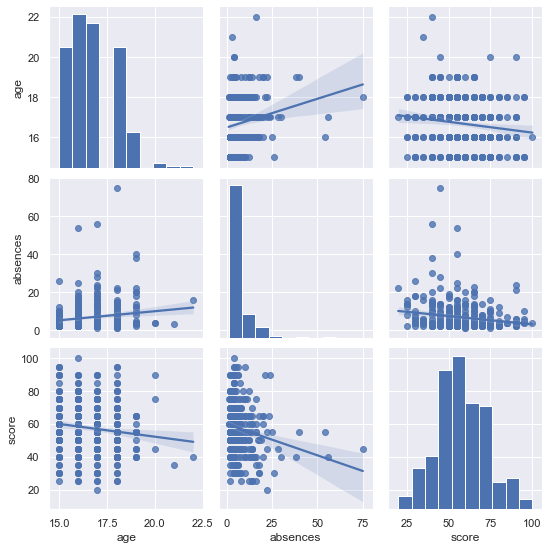

In [34]:
sns.pairplot(data[numeric], kind='reg')

In [35]:
data[numeric].corr()

,age,absences,score
age,1.000000,0.165568,-0.129911
absences,0.165568,1.000000,-0.183393
score,-0.129911,-0.183393,1.000000


числовые показатели слабо скореллированы;

при подготовке числовых показателей был замечен ряд особенностей, проверим догадки:

##### age

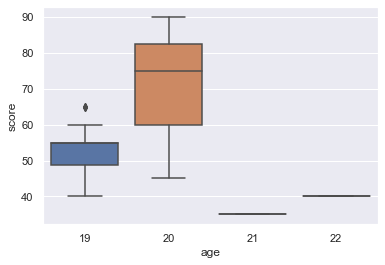

In [36]:
sns.boxplot(x='age', y='score', data=data[data.age >= 19])

догадка по возрасту частично подтвердилась. Учащиеся в возрасте 21 и 22 года имеют низкие баллы (40 и ниже), при этом у учащихся в возрасте 20 лет баллы достаточно высокие. Это позволяет сделать вывод, что возраст учащихся является определяющим критерием при значениях выше 20 лет. 

##### absences

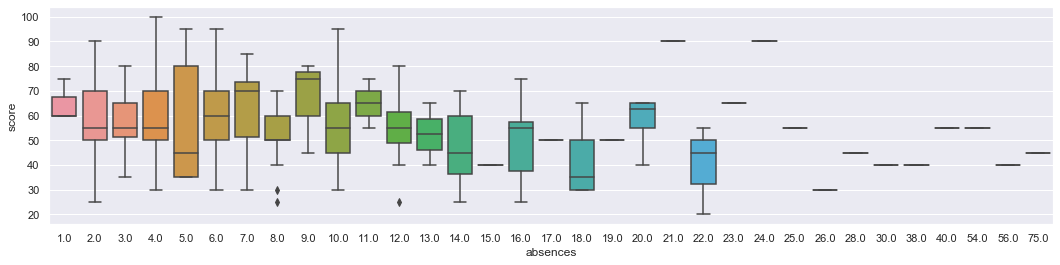

In [37]:
fig = plt.subplots(figsize=(18, 4))
sns.boxplot(x='absences', y='score', data=data)

догадка по пропускам также подтверждается. Учащиеся с количеством пропусков от 21 и выше в подавляющем большинстве имеют средний балл ниже 50, следовательно количество пропусков от 21 и выше следует считать еще одним критерием выявления студентов зоны риска

#### categorial

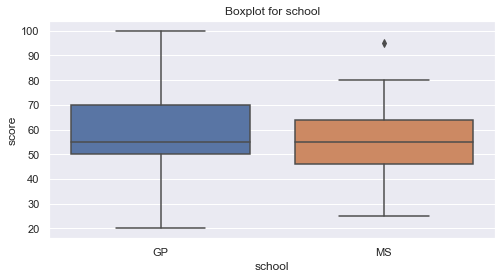

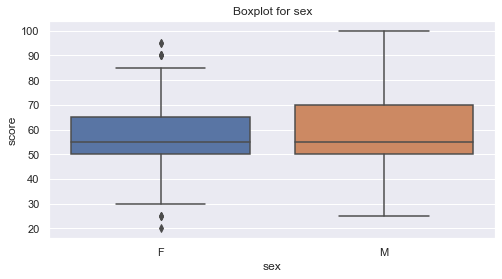

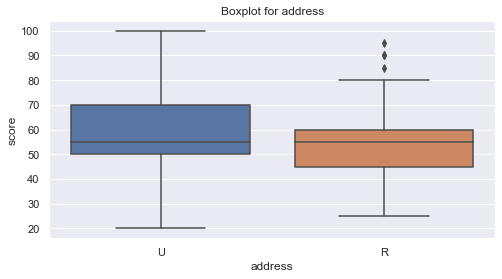

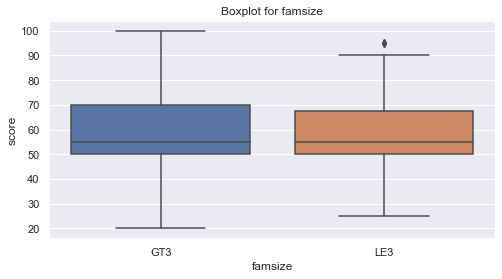

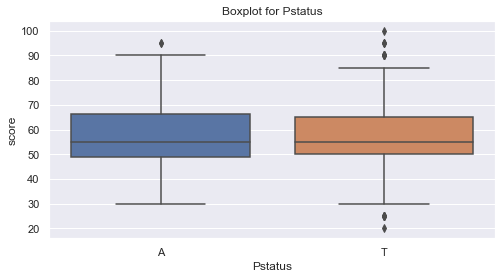

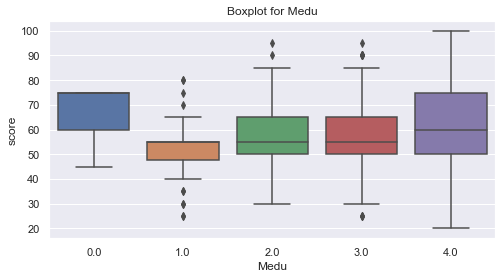

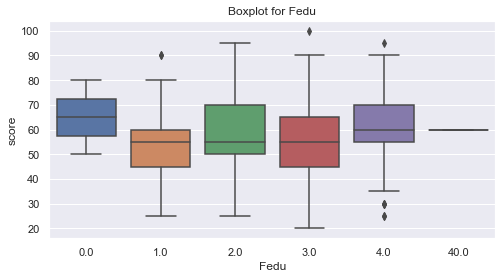

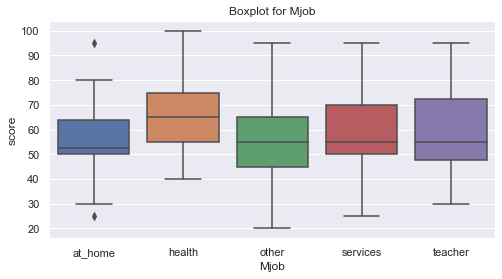

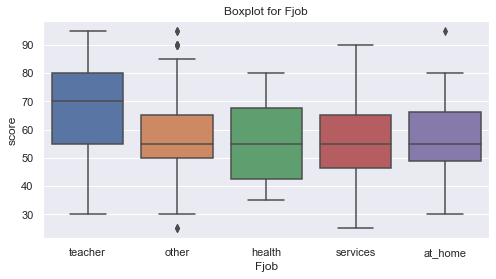

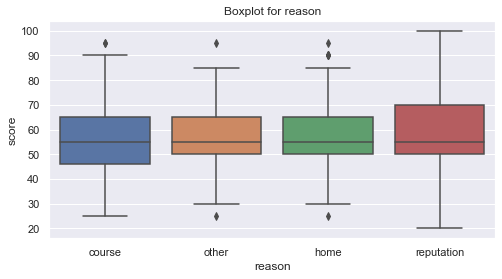

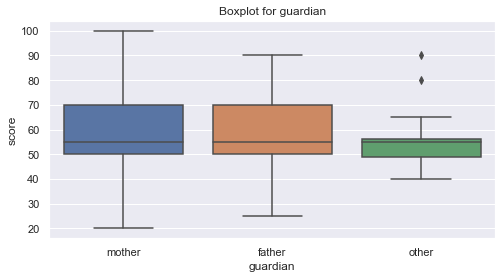

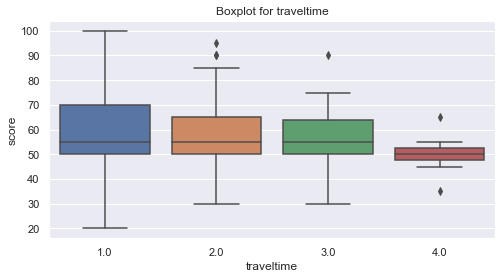

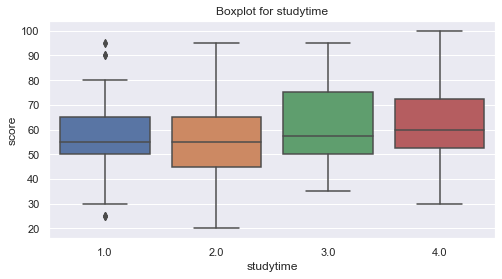

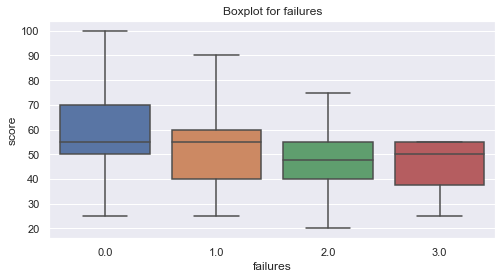

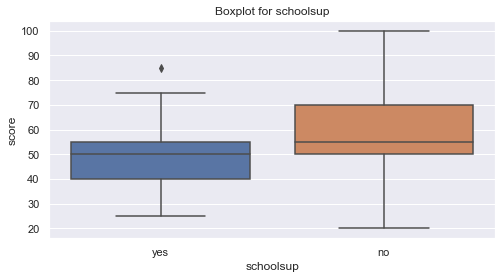

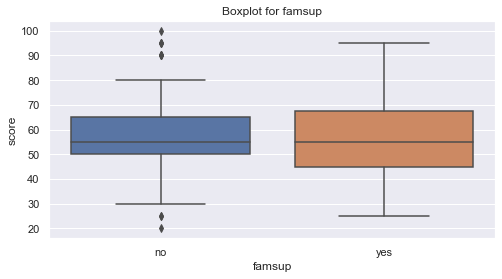

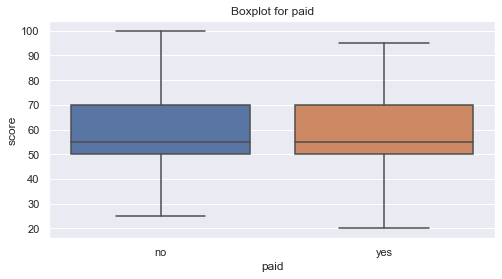

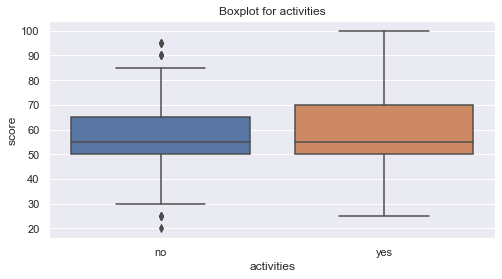

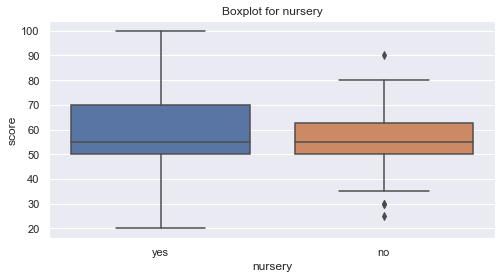

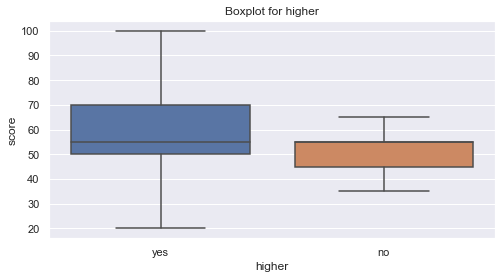

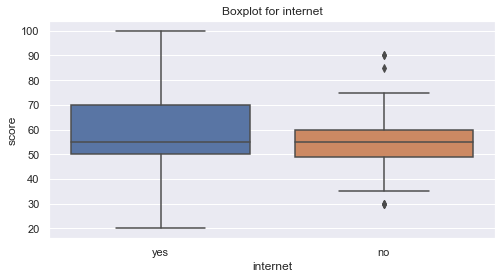

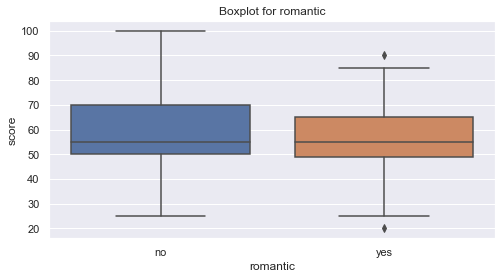

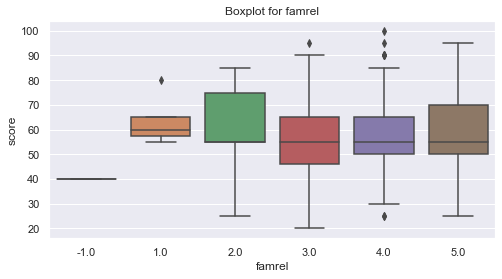

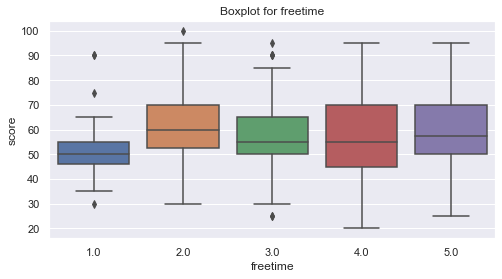

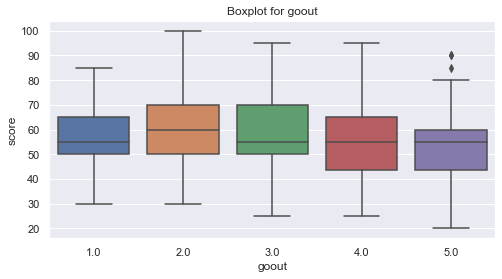

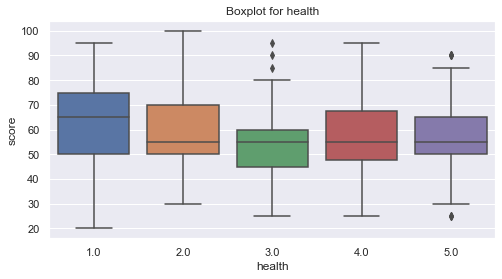

In [38]:
for column in categorial:
    get_boxplot(column)

в столбце Fedu есть ошибка - значение 40, хотя, согласно описанию, значения здесь должны варьироваться от 0 до 4. Скорее, всего была допущена ошибка и это не 40, а 4.0. Исправим это:

In [39]:
data.Fedu = data.Fedu.apply(lambda x: 4.0 if x == 40.0 else x)

в столбце famrel тоже есть ошибка - значение '-1', скорее всего, это 1, исправим: 

In [40]:
data.famrel = data.famrel.apply(lambda x: 1.0 if x == -1.0 else x)

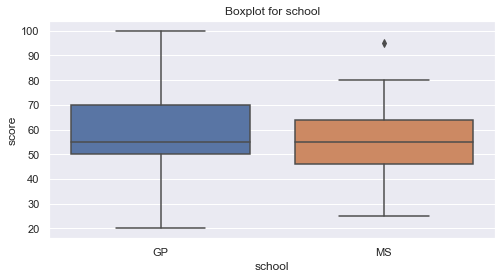

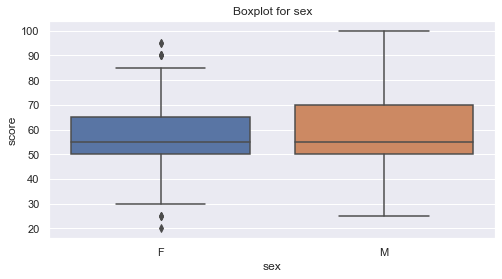

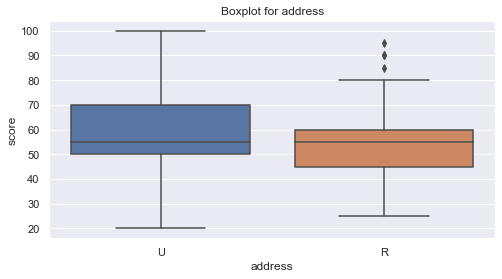

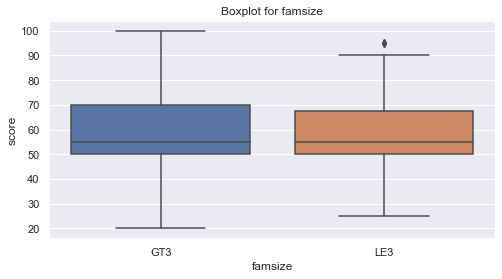

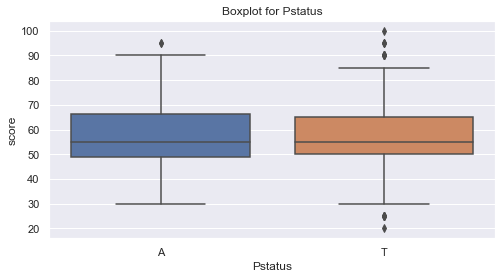

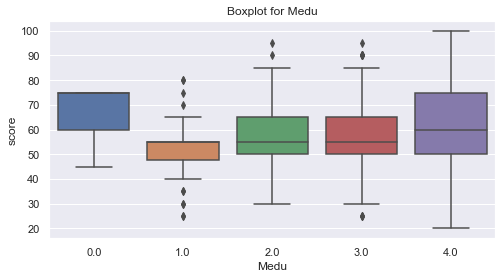

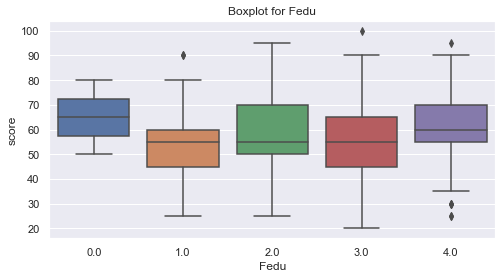

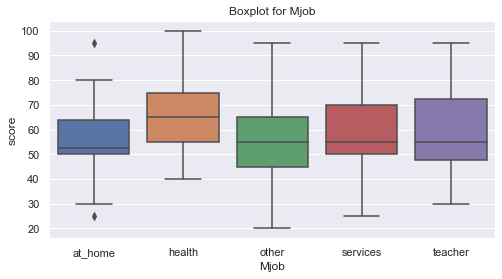

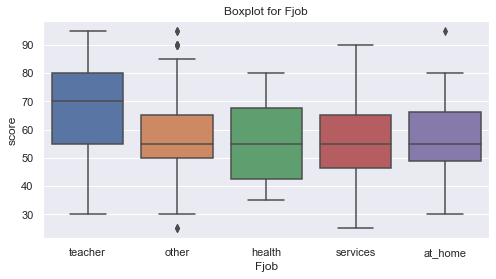

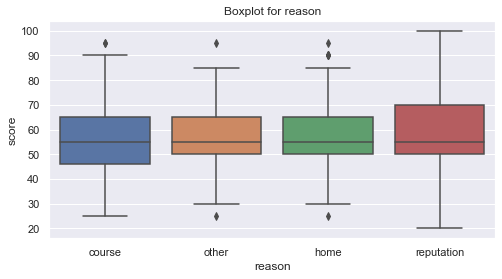

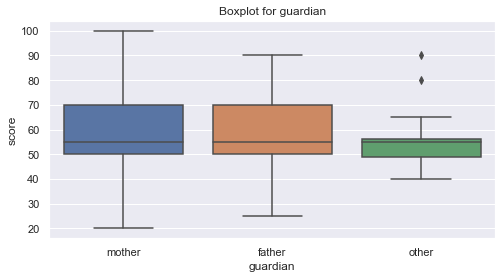

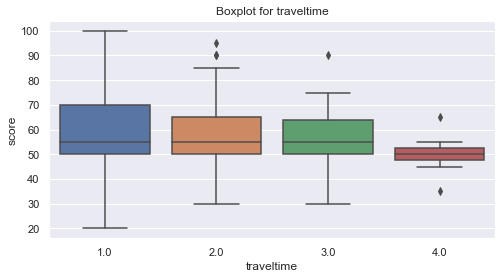

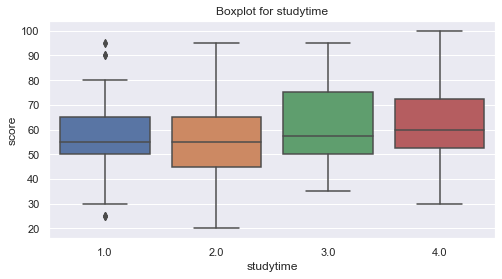

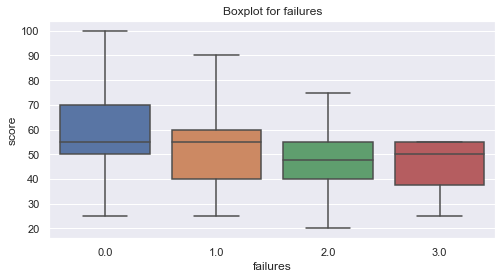

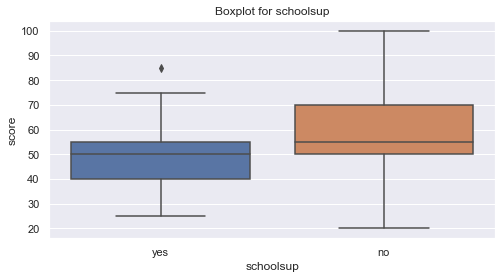

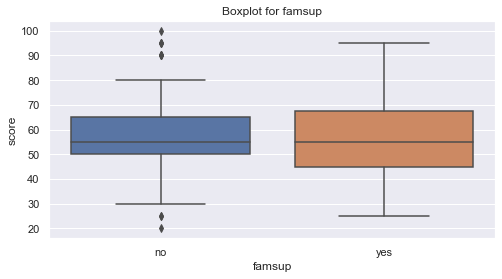

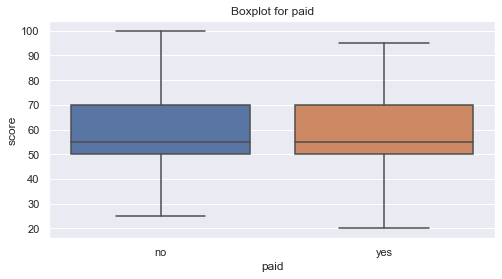

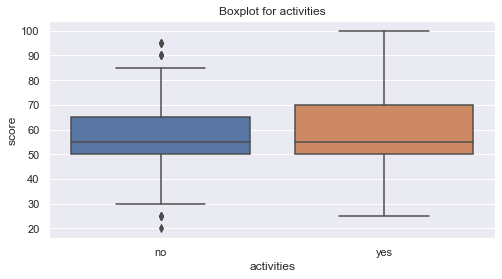

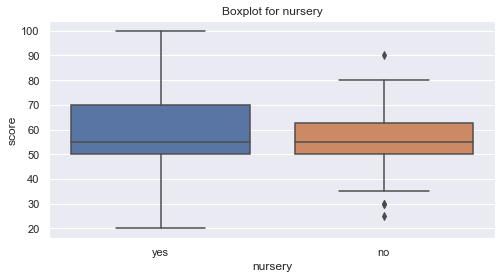

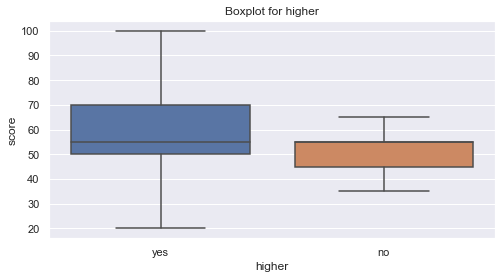

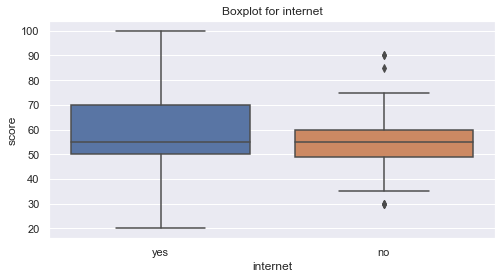

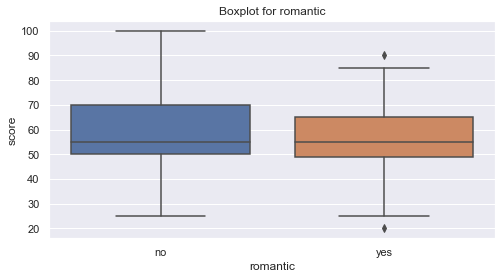

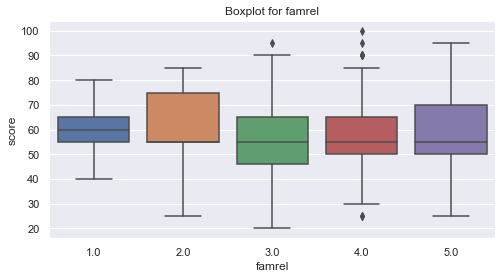

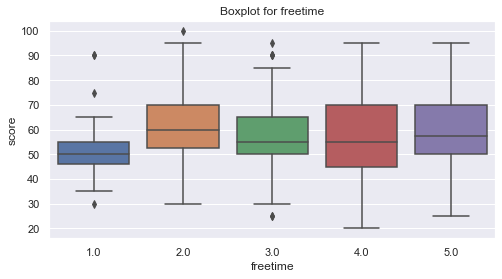

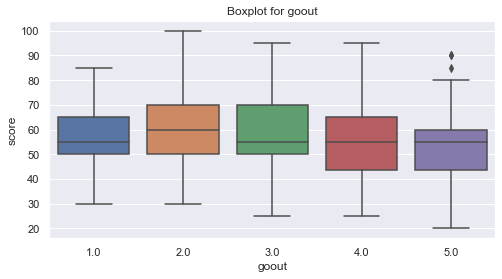

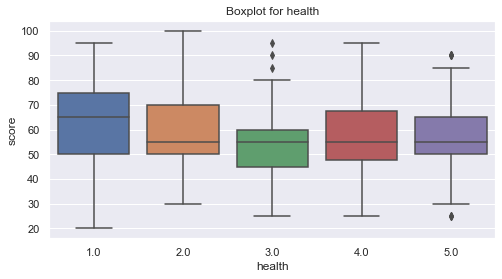

In [41]:
for column in categorial:
    get_boxplot(column)

Проверим нулевую гипотезу о том, что распределениe баллов по различным параметрам неразличимы:

In [42]:
for col in categorial:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Fedu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки Fjob
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки goout


Как было замечено при анализе столбца score, в исследуемой выборке очень много среднячков, поэтому во всех боксплотах можно видеть примерный средний уровень оценок в районе 50-60 баллов. Поскольку нас интересует выявление студентов, находящихся в группе риска, то оценки ниже 50 имеют для нас особую важность. 

Столбец 'sex' имеет статистически значимые различия, однако при визуальном анализе боксплотов можно заметить, что в целом средний показатель по оценкам для разных полов неизменен, при этом большая часть оценок (Q1 и выше) находится над уровнем 50 баллов, поэтому в модель этот показатель включать не будем.

### CONCLUSIONS

Данные в основном чистые, обнаружены всего пара незначительных ошибок, но при этом подавляющее большинство признаков содержит пустые значения. Из них в 14 было решено пропуски не заполнять, так как в них было более 5% пустых значений, и их заполнение могло исказить реальную картину. 

В модель будем включать следующие параметры: 
- age
- absences
- address
- Medu
- Fedu
- Mjob
- Fjob
- studytime
- failures
- schoolsup
- goout